# Imports

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from keras.applications import Xception
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential, Model
from keras import regularizers
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model

Using TensorFlow backend.


# Global variables

In [4]:
img_size = 299
batch_size = 32
epochs = 100
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

# Get classes and entries per classes

['Resume', 'Memo', 'News', 'Report', 'Scientific', 'Letter', 'Form', 'Email', 'ADVE', 'Note']
[121, 621, 189, 266, 262, 568, 432, 600, 231, 202]


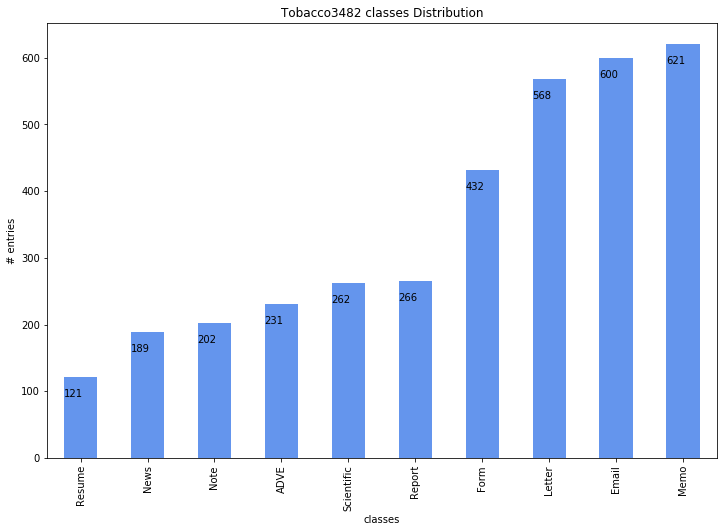

In [5]:
d = '../input/tobacco3482-jpg/Tobacco3482-jpg/'
PATH = '../'

classes = (os.listdir(d))

paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

nbEntries = []

for i in range(len(classes)):
    nbEntries.append(len(os.listdir(paths[i])))

#################################################
    
print(classes)
print(nbEntries)

df = pd.DataFrame({'classes':classes, 'entries':nbEntries})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 classes Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-30))

# Get all images

In [6]:
total_set = []
total_labels = []


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(root, file)
            total_set.append(path)
            total_labels.append(root.split(os.path.sep)[-1])
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

../input/tobacco3482-jpg/Tobacco3482-jpg/Resume/50476159-6160.jpg
GetClass :  Resume
Label :  Resume


# Plot data 

../input/tobacco3482-jpg/Tobacco3482-jpg/Report/506767138_506767143.jpg


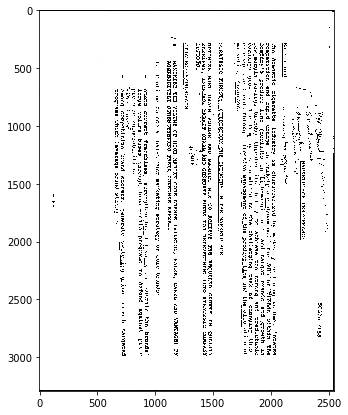

../input/tobacco3482-jpg/Tobacco3482-jpg/Email/529232712+-2723.jpg


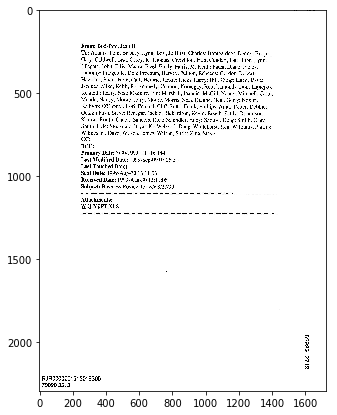

../input/tobacco3482-jpg/Tobacco3482-jpg/Memo/86280048_0055.jpg


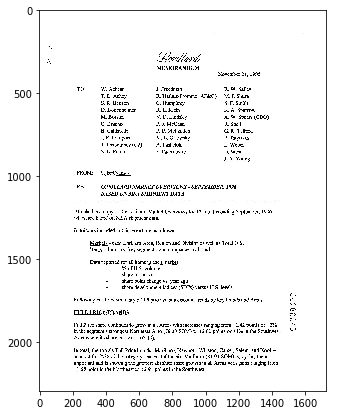

In [7]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()


# Sorting data in usable sets
![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [8]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])


../input/tobacco3482-jpg/Tobacco3482-jpg/Form/2070261623.jpg
Form


# Visualize classes distribution

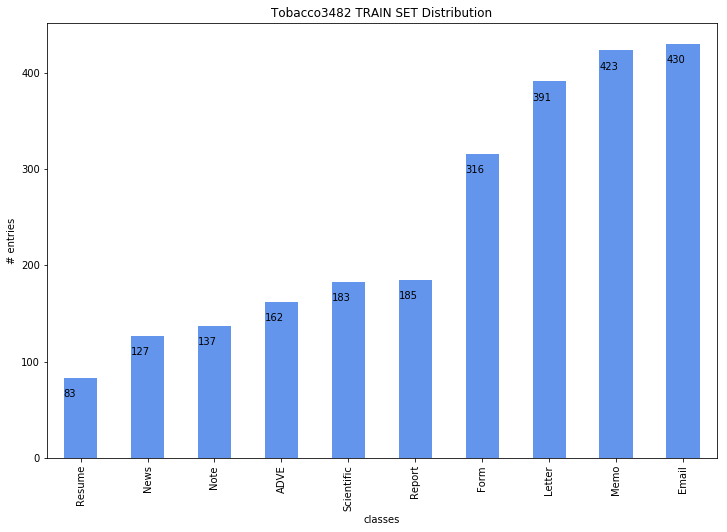

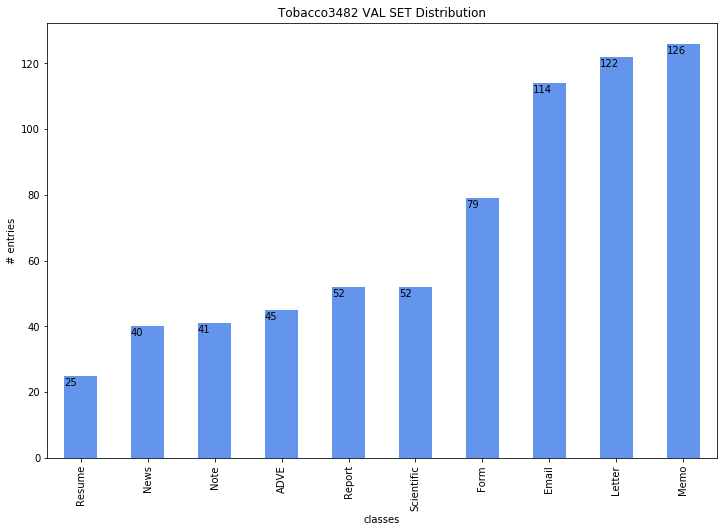

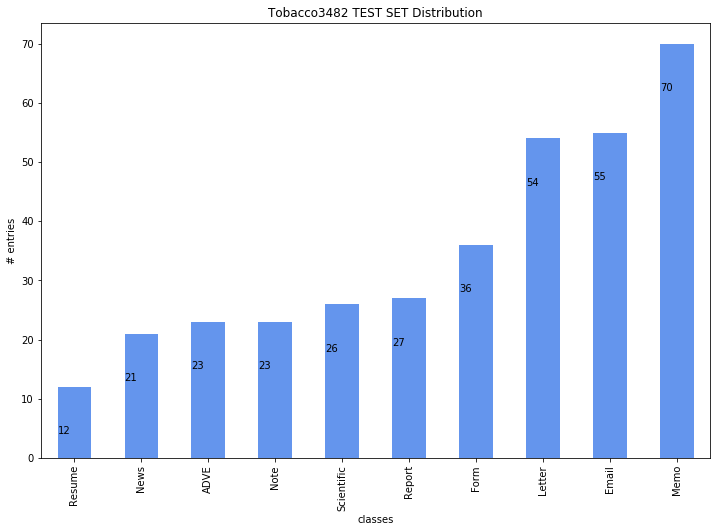

In [9]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

# Preprocess data (resize and transform to Numpy array)

In [10]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)) :
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_train = process_images(train_set)
x_test = process_images(test_set)
x_val = process_images(val_set)

train shape :  (2437, 299, 299, 3)
(2437, 10)
test shape :  (347, 299, 299, 3)
(347, 10)
valdiation shape :  (696, 299, 299, 3)
(696, 10)
Report
[0 0 0 0 0 0 0 1 0 0]
['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']


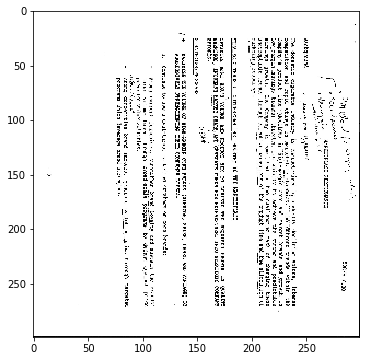

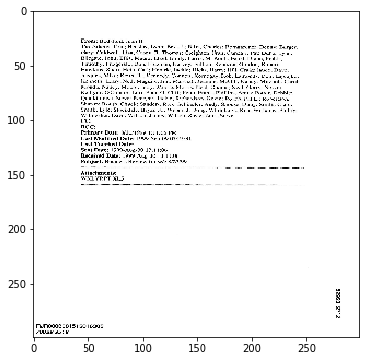

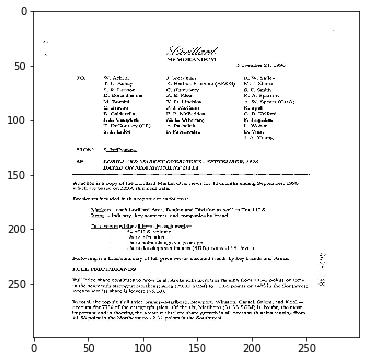

In [11]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(x_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(x_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(x_val)
y_val = lb.transform(np.array(val_label))

print("train shape : ", x_train.shape)
print(y_train.shape)
print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

# Creating model (pretrained CNN)

# Xception

In [ ]:
base_model = Xception(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# add your top layer block to your base model
model = Model(base_model.input, predictions)
    
model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# img_size = 224
# batch_size = 32
# epochs = 100
# train_size = 0.7
# val_size = 0.2
# test_size = 0.1
# seed = 4242
# channels = 3
# learning_rate = 0.00001.
epochs=5

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs= epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

# Plot accuracy and loss

In [ ]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

# Test prediction accuracy

In [ ]:
# score = model.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

In [ ]:
model.save('Xception_trained_model.h5')

In [ ]:
predictions = model.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

# VGG16

In [ ]:
# img_size = 224
# batch_size = 32
# epochs = 100
# train_size = 0.7
# val_size = 0.2
# test_size = 0.1
# seed = 4321
# channels = 3
# learning_rate = 0.00001

In [ ]:
from keras.applications import VGG16
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

In [ ]:
model1 = models.Sequential()
model1.add(base_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu',  name='dense',kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model1.summary()

print('Number of trainable weights : ', len(model1.trainable_weights))

plot_model(model1, to_file='model1.png')
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [ ]:
model1.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
epochs=100
train_model = model1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

In [ ]:
# combine predictions + average for better score ? 
# score = model1.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model1.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

In [ ]:
model1.save('VGG16_trained_model.h5')

In [ ]:
predictions = model1.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

# VGG19 ________________________________________________________________________________

In [42]:
from keras.applications import VGG19
base_model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 9, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1290      
Total params: 25,334,218
Trainable params: 25,334,218
Non-trainable params: 0
_________________________________________________________________
Number of trainable weights :  36


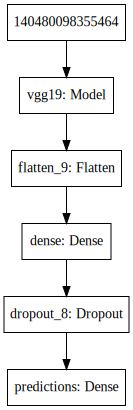

In [43]:
model1B = models.Sequential()
model1B.add(base_model)

model1B.add(layers.Flatten())
model1B.add(layers.Dense(128, activation='relu',  name='dense'))
model1B.add(layers.Dropout(0.5))
model1B.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model1B.summary()

print('Number of trainable weights : ', len(model1B.trainable_weights))

plot_model(model1B, to_file='model1B.png')
SVG(model_to_dot(model1B).create(prog='dot', format='svg'))

In [44]:
model1B.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
epochs=5
train_model = model1B.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

Train on 2437 samples, validate on 696 samples
Epoch 1/5
2437/2437 [==============================] - 75s 31ms/step - loss: 3.3157 - acc: 0.2622 - val_loss: 1.6674 - val_acc: 0.4856
Epoch 2/5


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2437/2437 [==============================] - 41s 17ms/step - loss: 1.5936 - acc: 0.4780 - val_loss: 1.2605 - val_acc: 0.6221
Epoch 3/5
2437/2437 [==============================] - 41s 17ms/step - loss: 1.2656 - acc: 0.5880 - val_loss: 0.9983 - val_acc: 0.6983
Epoch 4/5
2437/2437 [==============================] - 41s 17ms/step - loss: 1.0183 - acc: 0.6652 - val_loss: 0.8979 - val_acc: 0.7126
Epoch 5/5
2437/2437 [==============================] - 41s 17ms/step - loss: 0.8816 - acc: 0.7160 - val_loss: 0.8536 - val_acc: 0.7356


In [45]:
# combine predictions + average for better score ? 
# score = model1B.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model1B.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

2437/2437 [==============================] - 14s 6ms/step
Train loss: 0.5935496806022228
Train accuracy: 0.8157570784239677
347/347 [==============================] - 3s 8ms/step
Test loss: 0.7833721522639052
Test accuracy: 0.763688758917432


In [ ]:
model1B.save('VGG19_trained_model.h5')

In [ ]:
predictions = model1B.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

# EfficientNet-b3

In [ ]:
!pip install -U efficientnet

In [ ]:
# img_size = 224
# batch_size = 32
# epochs = 100
# train_size = 0.7
# val_size = 0.2
# test_size = 0.1
# seed = 4321
# channels = 3
# learning_rate = 0.00001

In [ ]:
import efficientnet.keras as EfficientNetB0

base_model = EfficientNetB0.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels))

# for layer in base_model.layers:
#     layer.trainable = False
    
base_model.summary()

In [ ]:
model2 = models.Sequential()

model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu',  name='dense',kernel_regularizer=regularizers.l2(0.01)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model2.summary()

print('Number of trainable weights : ', len(model2.trainable_weights))

plot_model(model2, to_file='model2.png')
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [ ]:
model2.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

In [ ]:
# combine predictions + average for better score ? 
# score = model2.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model2.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

In [ ]:
model2.save('EfficientNet_trained_model.h5')

In [ ]:
predictions = model2.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

# Resnet 50

In [ ]:
# img_size = 224
# batch_size = 32
# epochs = 40
# train_size = 0.7
# val_size = 0.2
# test_size = 0.1
# seed = 4321
# channels = 3
# learning_rate = 0.00001

In [12]:
from keras.applications import ResNet50
base_model = ResNet50(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26214528  
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1290      
Total params: 49,803,530
Trainable params: 49,750,410
Non-trainable params: 53,120
_________________________________________________________________
Number of trainable weights :  216


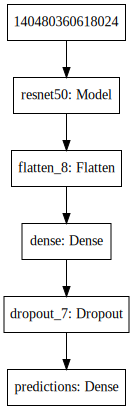

In [37]:
model3 = models.Sequential()
# keras.regularizers.L1L2(l1=0.01, l2=0.01)
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu',  name='dense',kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model3.summary()

print('Number of trainable weights : ', len(model3.trainable_weights))

plot_model(model3, to_file='model3.png')
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [40]:
model3.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
train_model = model3.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

Train on 2437 samples, validate on 696 samples
Epoch 1/10
2437/2437 [==============================] - 76s 31ms/step - loss: 514.8161 - acc: 0.7234 - val_loss: 445.8683 - val_acc: 0.7557
Epoch 2/10


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2437/2437 [==============================] - 34s 14ms/step - loss: 387.4486 - acc: 0.8252 - val_loss: 329.9117 - val_acc: 0.7845
Epoch 3/10
2437/2437 [==============================] - 34s 14ms/step - loss: 280.9878 - acc: 0.8765 - val_loss: 233.4265 - val_acc: 0.7874
Epoch 4/10
2437/2437 [==============================] - 34s 14ms/step - loss: 193.6084 - acc: 0.9130 - val_loss: 155.8262 - val_acc: 0.7989
Epoch 5/10
2437/2437 [==============================] - 34s 14ms/step - loss: 125.2696 - acc: 0.9307 - val_loss: 97.3610 - val_acc: 0.8032
Epoch 6/10
2437/2437 [==============================] - 34s 14ms/step - loss: 76.2708 - acc: 0.9389 - val_loss: 58.4386 - val_acc: 0.8075
Epoch 7/10
2437/2437 [==============================] - 34s 14ms/step - loss: 46.4393 - acc: 0.9508 - val_loss: 36.8474 - val_acc: 0.8175
Epoch 8/10
2437/2437 [==============================] - 34s 14ms/step - loss: 29.7730 - acc: 0.9598 - val_loss: 24.4110 - val_acc: 0.8103
Epoch 9/10
2437/2437 [================

In [41]:
# score = model3.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model3.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

2437/2437 [==============================] - 11s 5ms/step
Train loss: 11.546829200544268
Train accuracy: 0.9979482970865818
347/347 [==============================] - 2s 5ms/step
Test loss: 12.028234748400598
Test accuracy: 0.8069164287459953


In [ ]:
model3.save('ResNet50_trained_model.h5')

In [ ]:
predictions = model3.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

# InceptionV3

In [ ]:
# img_size = 299
# batch_size = 32
# epochs = 40
# train_size = 0.7
# val_size = 0.2
# test_size = 0.1
# seed = 4321
# channels = 3
# learning_rate = 0.00001

In [ ]:
from keras.applications import InceptionV3
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model4 = Model(inputs=base_model.input, outputs=predictions)

model4.summary()

print('Number of trainable weights : ', len(model4.trainable_weights))

plot_model(model4, to_file='model.png')
SVG(model_to_dot(model4).create(prog='dot', format='svg'))

In [ ]:
model4.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model4.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), # early stopping if accuracy doesnt change in 3 consecutive epochs
#                         tf.keras.callbacks.ModelCheckpoint(
#             'models/model_{val_accuracy:.3f}.h5',
#             save_best_only = True, save_weights_only = False, monitor = 'val_accuracy')
    ],
                        verbose=1,
                        validation_data=(x_val, y_val))

In [ ]:
# score = model4.evaluate(x_train, y_train, verbose=1)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])
# score = model4.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
print ('Training Accuracy = ' + str(train_model.history['accuracy']))
print ('Validation Accuracy = ' + str(train_model.history['val_accuracy']))

In [ ]:
model4.save('InceptionV3_trained_model.h5')

In [ ]:
predictions = model4.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))